# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [63]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})
import os

In [7]:
os.listdir()

['.ipynb_checkpoints',
 'BigARTM-0.8.0_.ipynb',
 'bigartm.DESKTOP-D7TE9IO.Даша.log.INFO.20201219-204733.1412',
 'bigartm.DESKTOP-D7TE9IO.Даша.log.WARNING.20201219-205849.1412',
 'C3W4 Gensim.ipynb',
 'C3W4 LDA Cooking Recipes.ipynb',
 'docword.xkcd.txt',
 'lda_xkcd',
 'lda_xkcd.expElogbeta.npy',
 'lda_xkcd.id2word',
 'lda_xkcd.state',
 'lectures.txt',
 'PostnaukaPeerReview.ipynb',
 'postnauka_batches',
 'recipes.json',
 'school.txt',
 'school_batches',
 'vocab.xkcd.txt']

In [5]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [8]:
# Ваш код
data = artm.BatchVectorizer(data_path='lectures.txt', data_format='vowpal_wabbit', target_folder='postnauka_batches', 
                           batch_size=50)


##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [32]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
artm_model = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={'text': 1, 'author': 1}, 
                      cache_theta=True, num_document_passes=1, seed=1, reuse_theta=True)


Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [33]:
# Ваш код
dictionary = artm.Dictionary(name='postanuka_dict')
dictionary.gather(data.data_path)

In [34]:
dictionary
artm_model.initialize(dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [35]:
# Ваш код
artm_model.scores.add(artm.TopTokensScore(class_id='text', num_tokens=15, name='top_words_text'))
artm_model.scores.add(artm.TopTokensScore(class_id='author', num_tokens=15, name='top_words_authors'))


##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [36]:
# Ваш код
artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, dictionary=dictionary, class_ids='text', 
                                                                topic_names='bcg', name='smooth_reg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [37]:
# Ваш код
artm_model.fit_offline(data, num_collection_passes=30)

In [41]:
for topic in artm_model.topic_names: 
    print(topic, end=' ')
    tokens = artm_model.score_tracker['top_words_text'].last_tokens
    for word in tokens[topic]: 
        print(word, end=' ')
    print()

sbj0 частица быть что это этот который взаимодействие кварк теория весь как физика симметрия такой они 
sbj1 быть это этот материал что который как мочь для такой структура при очень свойство они 
sbj2 быть что это политический который этот как государство власть тот такой очень для все свой 
sbj3 что этот это быть который язык как один система или мочь такой тот если университет 
sbj4 что быть это который этот человек мозг они как такой если мочь ребенок задача тот 
sbj5 быть что этот который это как они миф человек весь время такой она бог мир 
sbj6 быть это что этот который город как они русский очень человек такой текст для язык 
sbj7 это они что который человек этот быть как очень другой мочь или самый для трудность 
sbj8 право что этот быть это как который такой римский вещь мочь тот правовой если юрист 
sbj9 это быть что который этот мочь или пациент как заболевание человек болезнь очень когда боль 
sbj10 это быть что этот который они как такой год для мочь робот очень какой орг

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [43]:
# Ваш код
artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, dictionary=dictionary, class_ids='text', 
                                                                topic_names=topic_names[:-1], name='spar_reg'))

Выполните еще 15 проходов по коллекции.

In [44]:
# Ваш код
artm_model.fit_offline(data, num_collection_passes=15)

In [45]:
for topic in artm_model.topic_names: 
    print(topic, end=' ')
    tokens = artm_model.score_tracker['top_words_text'].last_tokens
    for word in tokens[topic]: 
        print(word, end=' ')
    print()

C:\Users\Dasha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sbj0 частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый 
sbj1 материал температура структура вещество химический соединение свойство поверхность химия давление углерод сверхпроводимость металл применение полимер 
sbj2 политический государство политика царь партия власть правитель враг сага кризис ритуал шмитт государь средневековый египетский 
sbj3 знание университет образование школа предмет восприятие познание факультет аргумент студент логика кафедра прикладной концепт гумбольдт 
sbj4 мозг ребенок нейрон мышление предложение категория взрослый чтение лицо синтаксический синтаксис устный обезьяна детство словосочетание 
sbj5 бог миф греческий герой море мифология грек мифологический гусейнов персонаж шумерский гасан божество сущность генеалогия 
sbj6 русский город текст городской перевод корпус гласный документ говор москва пьеса горожанин немецкий древнерусский метро 
sbj7 трудность раса праздник шаман а

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [53]:
# Ваш код
for topic in artm_model.topic_names: 
    print(topic)
    authors = artm_model.score_tracker['top_words_authors'].last_tokens
    tokens = artm_model.score_tracker['top_words_text'].last_tokens
    for word in tokens[topic]: 
        print(word, end=' ')
    print()
    for author in authors[topic]: 
        print(author, end=' ')
    print()

sbj0
частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый 
Дмитрий_Казаков Михаил_Данилов Сергей_Майоров Виктор_Брагута Павел_Пахлов Игорь_Волобуев Валерий_Рубаков Сергей_Троицкий Лев_Дудко Лев_Беклемишев Анатолий_Лиходед Эдуард_Боос Аркадий_Цейтлин Сергей_Кетов Дэвид_Гросс 
sbj1
материал температура структура вещество химический соединение свойство поверхность химия давление углерод сверхпроводимость металл применение полимер 
Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Валентин_Крапошин Евгений_Гудилин Дмитрий_Гольберг Владимир_Пудалов Иван_Сорокин Наталья_Берлофф Дмитрий_Клинов Сергей_Морозов Евгений_Антипов Вадим_Бражкин Владимир_Комлев 
sbj2
политический государство политика царь партия власть правитель враг сага кризис ритуал шмитт государь средневековый египетский 
Алексей_Юдин Михаил_Бойцов Дина_Гусейнова Иван_Ладынин Андрей_Лукашов Татьяна_Смоктунович Зоригто_Намсараев Владимир_Мал

революция власть король французский реформа петр франция против сталин император народ крестьянин террор диктатура смерть 
Александр_Марей Дмитрий_Бовыкин Павел_Уваров Кирилл_Соловьев Алина_Бодрова Олег_Мельник Игорь_Курукин Олег_Хлевнюк Дмитрий_Дагаев Екатерина_Лямина Ольга_Вайнштейн Илья_Иткин Борис_Колоницкий Алексей_Руткевич Илья_Кукулин 
sbj23
советский россия война мировой гражданский песня союз обряд екатерина самка ссср самец эмиграция армия большевик 
Вера_Мильчина Ирина_Бёме Анна_Соколова Олег_Будницкий Варвара_Веденина Борис_Колоницкий Людмила_Новикова Илья_Кукулин Михаил_Бойцов Архат_Абжанов Пол_Грегори Марк_Харрисон Эдуард_Пройдаков Олег_Ауров Андрей_Журавлев 
sbj24
язык христианский литературный литература лингвист христианство глагол филологический лингвистика языковой грамматика христианин арабский падеж английский 
Алексей_Муравьёв Владимир_Плунгян Олег_Воскобойников Андрей_Кибрик Мария_Штейнман Олег_Лекманов Петр_Аркадьев Владимир_Беликов Светлана_Бурлак Максим_Кронга

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [343]:
sbj_topic_labels = ['Физика элементарных частиц', 
                   'Химия', 
                   'История', 
                   'Образование', 
                   'Клиническая психология', 
                   'Мифология', 
                   'Культура', 
                   'Антропология', 
                   'Право', 
                   'Медицина', 
                   'Биология', 
                   'Психология',
                   'История России', 
                   'Наука', 'Астрономия', 'Экономика', 'Поведенческая психология', 
                   'Компьютерные науки', 'История Востока', 'Генетика', 'Оптика', 
                   'Философия', 'История России_2', 'История СССР', 
                   'Литература', 'Математика', 'Искусство', 'Астрономия_2', 'Кинематография']   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [136]:
artm_model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = artm_model.get_theta()
phi_a = artm_model.get_phi(class_ids='author')
phi_a.columns = topic_labels

C:\Users\Dasha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

<AxesSubplot:>

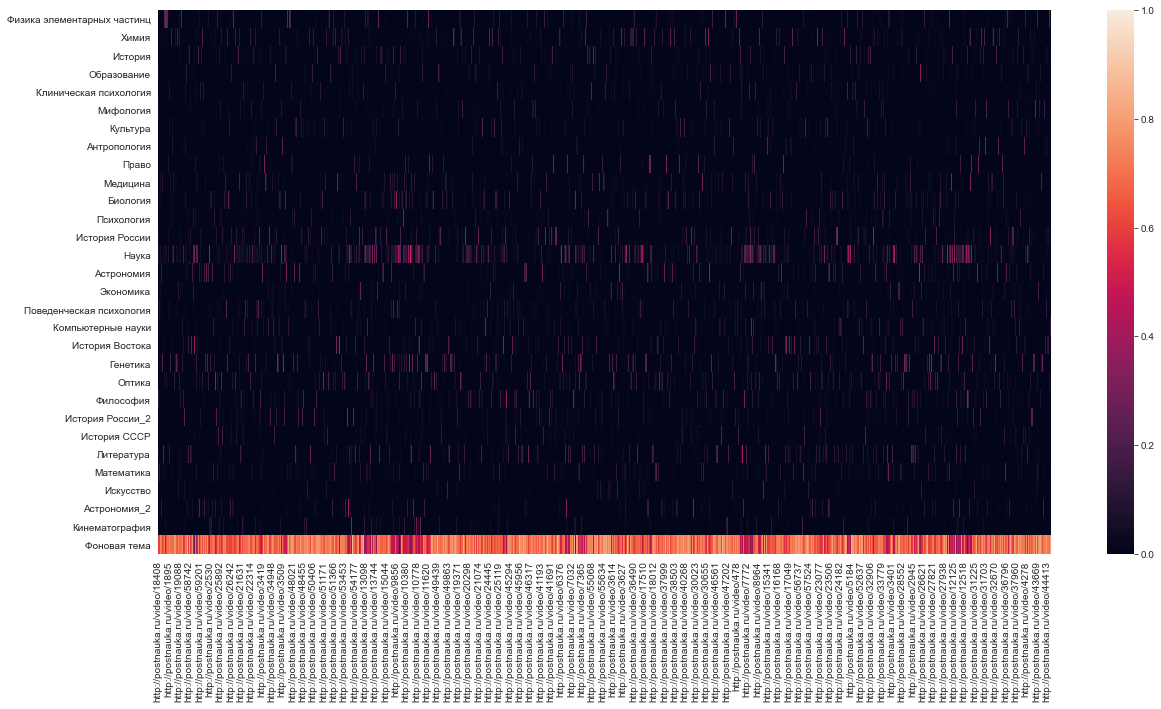

In [69]:
# Ваш код
plt.figure(figsize=(20, 10))
sns.heatmap(theta, vmin=0, vmax=1, yticklabels=topic_labels)

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [110]:
# Ваш код
t_distr = pd.Series(theta.sum(axis=1) / theta.sum(axis=1).sum())

C:\Users\Dasha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
t_distr.index = topic_labels

In [126]:
print(t_distr.drop(['Фоновая_тема', 'Наука']).sort_values()[:3])
print(t_distr.drop(['Фоновая_тема', 'Наука']).sort_values()[-5:])

Искусство       0.003080
Антропология    0.004714
Психология      0.005457
dtype: float32
Астрономия    0.014994
Литература    0.015090
Биология      0.015111
Оптика        0.016716
Генетика      0.021598
dtype: float32


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

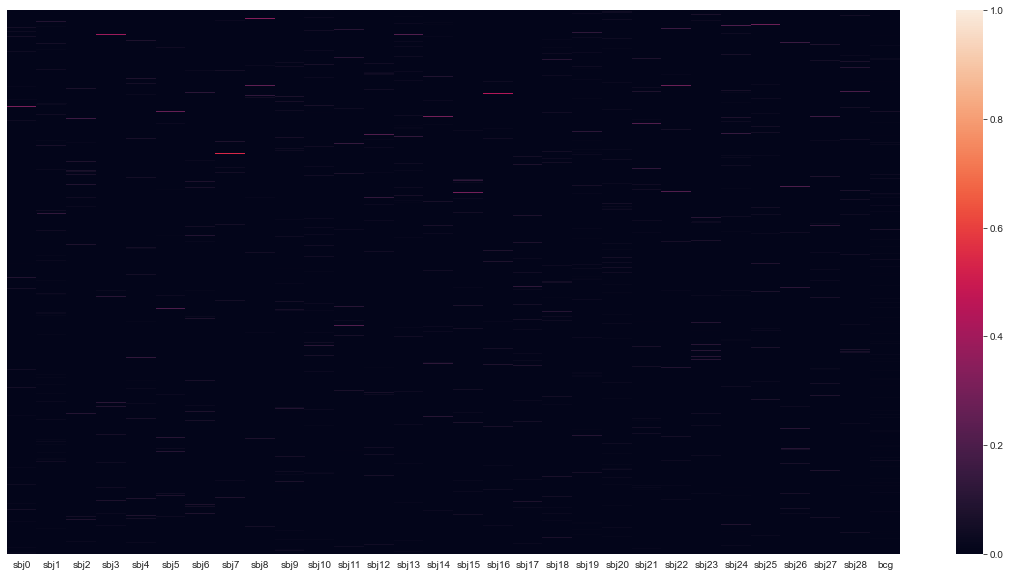

In [128]:
# Ваш код
plt.figure(figsize=(20, 10))
sns.heatmap(phi_a, yticklabels=False, vmin=0, vmax=1);

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [160]:
phi_a[(phi_a.iloc[:, :-1] > 0.01).sum(axis=1) >= 3]

,Физика_элементарных_частинц,Химия,История,Образование,Клиническая_психология,Мифология,Культура,Антропология,Право,Медицина,...,Оптика,Философия,История_России_2,История_СССР,Литература,Математика,Искусство,Астрономия_2,Кинематография,Фоновая_тема
"(author, Фёдор_Успенский)",0.0,0.0,0.039787,0.000000,0.0,0.000034,0.000000,0.0,0.016691,0.0,...,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,0.016304
"(author, Илья_Иткин)",0.0,0.0,0.000000,0.027068,0.0,0.000340,0.013146,0.0,0.000000,0.0,...,0.0,0.0,0.015739,0.000000,2.544209e-02,0.0,0.000000,0.0,0.0,0.000000
"(author, Олег_Ауров)",0.0,0.0,0.000000,0.000000,0.0,0.032617,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.025665,1.530711e-02,0.0,0.000000,0.0,0.0,0.000000
"(author, Андрей_Журавлев)",0.0,0.0,0.000000,0.000000,0.0,0.043349,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.021294,0.000000e+00,0.0,0.055810,0.0,0.0,0.000000
"(author, Александр_Пиперски)",0.0,0.0,0.000000,0.025249,0.0,0.000000,0.080248,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,3.464326e-07,0.0,0.026862,0.0,0.0,0.000000


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [155]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

C:\Users\Dasha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [176]:
authors_themes = np.zeros(phi_a.shape)

In [187]:
for i in range(phi_a.shape[0]): 
    for j in range(phi_a.shape[1]): 
        authors_themes[i, j] = (phi_a.iloc[i, j] * t_distr.iloc[j]) / np.sum((phi_a.iloc[i, :] * t_distr.values))
        

In [191]:
authors_themes = pd.DataFrame(authors_themes, index=phi_a.index, columns=topic_labels)

C:\Users\Dasha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [201]:
cosine_sim = pairwise_distances(authors_themes, metric='cosine')

C:\Users\Dasha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [210]:
mds = MDS(n_components=2, dissimilarity='precomputed')

In [213]:
authors_themes_mds = mds.fit_transform(X=cosine_sim)

C:\Users\Dasha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Визуализируйте найденные двумерные представления с помощью функции scatter. 

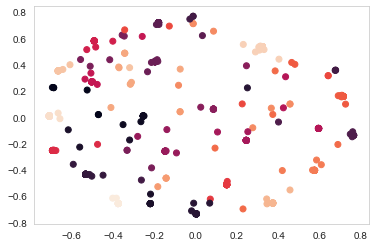

In [238]:
# Ваш код
plt.scatter(authors_themes_mds[:, 0], authors_themes_mds[:, 1], c=domain_themes_encoder);

In [232]:
domain_theme = authors_themes.idxmax(axis=1).values

In [234]:
from sklearn.preprocessing import LabelEncoder

In [237]:
le = LabelEncoder()
domain_themes_encoder = le.fit_transform(domain_theme)

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [241]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем

In [272]:
authors = np.array(phi_a.index.to_list())[:, 1]

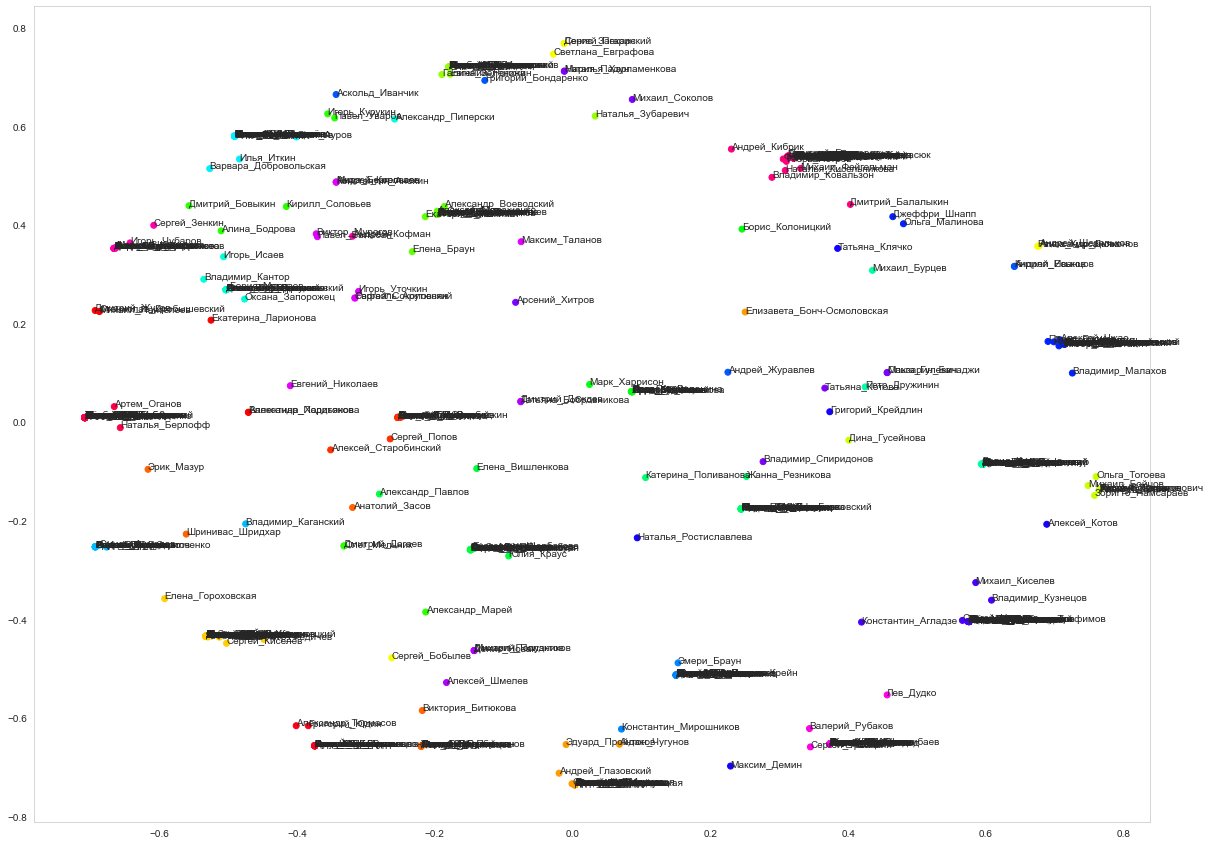

In [331]:
plt.figure(figsize=(20, 15))
plt.scatter(authors_themes_mds[:, 0], authors_themes_mds[:, 1], c=domain_themes_encoder, cmap='hsv')

for i, author in enumerate(authors): 
    plt.annotate(author, (authors_themes_mds[i, 0], authors_themes_mds[i, 1]))

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [278]:
# Ваш код
p_dt = np.zeros(theta.shape)
for i in range(theta.shape[0]): 
    for j in range(theta.shape[1]): 
        p_dt[i, j] = theta.iloc[i, j] / (theta.iloc[i, :].sum())


In [285]:
p_dt = pd.DataFrame(p_dt, columns=theta.columns, index=theta.index)

In [288]:
p_dt.head()

,http://postnauka.ru/video/18408,http://postnauka.ru/video/18409,http://postnauka.ru/video/1850,http://postnauka.ru/video/1856,http://postnauka.ru/video/18603,http://postnauka.ru/video/18613,http://postnauka.ru/video/18637,http://postnauka.ru/video/1870,http://postnauka.ru/video/18739,http://postnauka.ru/video/18742,...,http://postnauka.ru/video/44273,http://postnauka.ru/video/44274,http://postnauka.ru/video/44413,http://postnauka.ru/video/44543,http://postnauka.ru/video/44728,http://postnauka.ru/video/44729,http://postnauka.ru/video/44730,http://postnauka.ru/video/44739,http://postnauka.ru/video/44740,http://postnauka.ru/video/44742
sbj0,0.000826,8.688022e-16,0.000000,0.000000e+00,4.924095e-04,0.000000e+00,0.000000,2.466295e-15,0.000734,2.476425e-05,...,1.173573e-08,2.513305e-12,5.887160e-06,2.639942e-12,1.387409e-06,1.034648e-08,1.555381e-10,9.551945e-08,0.013737,1.689609e-07
sbj1,0.002645,1.693991e-14,0.000000,3.172838e-09,7.904801e-04,0.000000e+00,0.000000,1.751300e-06,0.001739,1.072243e-03,...,6.578450e-12,1.446766e-09,1.363892e-17,2.070810e-04,0.000000e+00,4.831736e-09,1.073034e-14,1.992009e-04,0.000019,1.829667e-08
sbj2,0.000000,9.394373e-09,0.000350,0.000000e+00,0.000000e+00,0.000000e+00,0.000839,0.000000e+00,0.000000,8.987320e-12,...,1.935075e-03,2.108858e-04,7.687347e-09,0.000000e+00,3.218904e-03,2.476498e-03,1.670198e-03,0.000000e+00,0.000000,0.000000e+00
sbj3,0.000305,1.241557e-09,0.002486,7.285247e-17,1.197846e-14,7.777072e-15,0.000000,0.000000e+00,0.000000,2.838577e-04,...,4.707934e-06,5.468251e-14,7.209305e-08,0.000000e+00,1.697317e-09,3.967009e-09,0.000000e+00,1.365803e-08,0.000000,1.731683e-06
sbj4,0.000000,2.564141e-04,0.000312,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,...,8.816438e-18,1.384239e-04,3.087395e-07,1.069935e-03,1.241326e-12,0.000000e+00,5.123430e-17,8.300662e-11,0.000000,1.003906e-07


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [279]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [289]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

C:\Users\Dasha\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [347]:
topic_subject = {sub: top for sub, top in zip(topic_names, topic_labels)}

In [352]:
def navigator(topic): 
    display(HTML(f'<h2><font color=" #148f77">{topic_subject[topic].replace("_", " ")}</font></h2>'))
    display(HTML(f'<h3>Ключевые слова</h3>'))
    print(artm_model.score_tracker['top_words_text'].last_tokens[topic])
    print()
    display(HTML('<h3>Ссылки на документы</h3>'))
    print(*p_dt.loc[topic, :].sort_values(ascending=False).index.to_list()[:10], sep='\n')
    

In [354]:
for topic in topic_names: 
    navigator(topic)

['частица', 'взаимодействие', 'физика', 'кварк', 'симметрия', 'элементарный', 'нейтрино', 'стандартный', 'материя', 'протон', 'бозон', 'заряд', 'масса', 'ускоритель', 'слабый']



http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/18873
http://postnauka.ru/video/47950
http://postnauka.ru/video/2945
http://postnauka.ru/video/11634
http://postnauka.ru/video/1894
http://postnauka.ru/video/47175
http://postnauka.ru/video/14282
http://postnauka.ru/video/478


['материал', 'температура', 'структура', 'вещество', 'химический', 'соединение', 'свойство', 'поверхность', 'химия', 'давление', 'углерод', 'сверхпроводимость', 'металл', 'применение', 'полимер']



http://postnauka.ru/video/31182
http://postnauka.ru/video/13700
http://postnauka.ru/video/57995
http://postnauka.ru/video/18048
http://postnauka.ru/video/41686
http://postnauka.ru/video/13544
http://postnauka.ru/video/51490
http://postnauka.ru/video/50340
http://postnauka.ru/video/46379
http://postnauka.ru/video/56295


['политический', 'государство', 'политика', 'царь', 'партия', 'власть', 'правитель', 'враг', 'сага', 'кризис', 'ритуал', 'шмитт', 'государь', 'средневековый', 'египетский']



http://postnauka.ru/video/5517
http://postnauka.ru/video/5179
http://postnauka.ru/video/32906
http://postnauka.ru/video/13538
http://postnauka.ru/video/52941
http://postnauka.ru/video/32882
http://postnauka.ru/video/12083
http://postnauka.ru/video/56304
http://postnauka.ru/video/59199
http://postnauka.ru/video/53228


['знание', 'университет', 'образование', 'школа', 'предмет', 'восприятие', 'познание', 'факультет', 'аргумент', 'студент', 'логика', 'кафедра', 'прикладной', 'концепт', 'гумбольдт']



http://postnauka.ru/video/2973
http://postnauka.ru/video/31198
http://postnauka.ru/video/19570
http://postnauka.ru/video/35038
http://postnauka.ru/video/55533
http://postnauka.ru/video/49445
http://postnauka.ru/video/40889
http://postnauka.ru/video/55217
http://postnauka.ru/video/50406
http://postnauka.ru/video/3603


['мозг', 'ребенок', 'нейрон', 'мышление', 'предложение', 'категория', 'взрослый', 'чтение', 'лицо', 'синтаксический', 'синтаксис', 'устный', 'обезьяна', 'детство', 'словосочетание']



http://postnauka.ru/video/50793
http://postnauka.ru/video/55068
http://postnauka.ru/video/12521
http://postnauka.ru/video/47548
http://postnauka.ru/video/26207
http://postnauka.ru/video/5178
http://postnauka.ru/video/25891
http://postnauka.ru/video/27965
http://postnauka.ru/video/36350
http://postnauka.ru/video/7767


['бог', 'миф', 'греческий', 'герой', 'море', 'мифология', 'грек', 'мифологический', 'гусейнов', 'персонаж', 'шумерский', 'гасан', 'божество', 'сущность', 'генеалогия']



http://postnauka.ru/video/43664
http://postnauka.ru/video/5181
http://postnauka.ru/video/27831
http://postnauka.ru/video/42796
http://postnauka.ru/video/31990
http://postnauka.ru/video/21637
http://postnauka.ru/video/46427
http://postnauka.ru/video/12527
http://postnauka.ru/video/36716
http://postnauka.ru/video/47300


['русский', 'город', 'текст', 'городской', 'перевод', 'корпус', 'гласный', 'документ', 'говор', 'москва', 'пьеса', 'горожанин', 'немецкий', 'древнерусский', 'метро']



http://postnauka.ru/video/13156
http://postnauka.ru/video/51171
http://postnauka.ru/video/8964
http://postnauka.ru/video/24279
http://postnauka.ru/video/48112
http://postnauka.ru/video/24945
http://postnauka.ru/video/47301
http://postnauka.ru/video/57318
http://postnauka.ru/video/23470
http://postnauka.ru/video/10773


['трудность', 'раса', 'праздник', 'шаман', 'америка', 'станислав', 'африка', 'тест', 'нос', 'монголоид', 'дробышевский', 'шаманский', 'индеец', 'сакральный', 'задание']



http://postnauka.ru/video/31707
http://postnauka.ru/video/37732
http://postnauka.ru/video/32898
http://postnauka.ru/video/35150
http://postnauka.ru/video/42707
http://postnauka.ru/video/15341
http://postnauka.ru/video/42735
http://postnauka.ru/video/17397
http://postnauka.ru/video/31675
http://postnauka.ru/video/40880


['право', 'римский', 'правовой', 'юрист', 'суд', 'юридический', 'сон', 'должник', 'собственность', 'обязательство', 'закон', 'владение', 'собственник', 'имущество', 'исполнение']



http://postnauka.ru/video/9299
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/49455
http://postnauka.ru/video/17912
http://postnauka.ru/video/16822
http://postnauka.ru/video/42221
http://postnauka.ru/video/31688
http://postnauka.ru/video/31666
http://postnauka.ru/video/17875


['болезнь', 'заболевание', 'пациент', 'лечение', 'медицина', 'врач', 'боль', 'препарат', 'медицинский', 'иммунный', 'операция', 'озеро', 'сердце', 'диагностика', 'нарушение']



http://postnauka.ru/video/13746
http://postnauka.ru/video/532
http://postnauka.ru/video/7753
http://postnauka.ru/video/11361
http://postnauka.ru/video/12974
http://postnauka.ru/video/2541
http://postnauka.ru/video/49206
http://postnauka.ru/video/11850
http://postnauka.ru/video/45961
http://postnauka.ru/video/51384


['животное', 'робот', 'растение', 'вода', 'организм', 'микроорганизм', 'нервный', 'рецептор', 'биологический', 'эволюция', 'мембрана', 'метан', 'кислород', 'мышца', 'микроб']



http://postnauka.ru/video/9861
http://postnauka.ru/video/30673
http://postnauka.ru/video/8953
http://postnauka.ru/video/2531
http://postnauka.ru/video/32635
http://postnauka.ru/video/7113
http://postnauka.ru/video/19071
http://postnauka.ru/video/25889
http://postnauka.ru/video/49437
http://postnauka.ru/video/10786


['память', 'информация', 'когнитивный', 'зрительный', 'процесс', 'запоминать', 'психолог', 'линзовидный', 'воспроизводить', 'картинка', 'храниться', 'мария', 'кора', 'хранение', 'катастрофа']



http://postnauka.ru/video/9997
http://postnauka.ru/video/56052
http://postnauka.ru/video/54916
http://postnauka.ru/video/57336
http://postnauka.ru/video/37979
http://postnauka.ru/video/27845
http://postnauka.ru/video/38507
http://postnauka.ru/video/3645
http://postnauka.ru/video/17421
http://postnauka.ru/video/23079


['империя', 'германия', 'историк', 'церковь', 'государственный', 'русь', 'святой', 'военный', 'российский', 'великий', 'князь', 'немецкий', 'война', 'нация', 'культ']



http://postnauka.ru/video/24034
http://postnauka.ru/video/3348
http://postnauka.ru/video/24039
http://postnauka.ru/video/32637
http://postnauka.ru/video/19574
http://postnauka.ru/video/23900
http://postnauka.ru/video/35041
http://postnauka.ru/video/50668
http://postnauka.ru/video/31183
http://postnauka.ru/video/34936


['наука', 'социальный', 'рассказывать', 'общество', 'понятие', 'исторический', 'кандидат', 'история', 'социология', 'каков', 'культурный', 'сегодня', 'научный', 'сообщество', 'искусство']



http://postnauka.ru/video/10783
http://postnauka.ru/video/10749
http://postnauka.ru/video/9148
http://postnauka.ru/video/7778
http://postnauka.ru/video/9870
http://postnauka.ru/video/17491
http://postnauka.ru/video/5878
http://postnauka.ru/video/3417
http://postnauka.ru/video/6380
http://postnauka.ru/video/5198


['галактика', 'планета', 'земля', 'звезда', 'черный', 'дыра', 'масса', 'газ', 'атмосфера', 'диск', 'солнечный', 'солнце', 'космический', 'расстояние', 'скопление']



http://postnauka.ru/video/2971
http://postnauka.ru/video/9835
http://postnauka.ru/video/31193
http://postnauka.ru/video/57338
http://postnauka.ru/video/31695
http://postnauka.ru/video/36249
http://postnauka.ru/video/3604
http://postnauka.ru/video/3423
http://postnauka.ru/video/58744
http://postnauka.ru/video/45644


['решение', 'экономический', 'экономика', 'деньги', 'компания', 'принятие', 'ценность', 'международный', 'выбор', 'ресурс', 'рынок', 'экономист', 'безопасность', 'эффективность', 'доверие']



http://postnauka.ru/video/53415
http://postnauka.ru/video/5465
http://postnauka.ru/video/13152
http://postnauka.ru/video/24286
http://postnauka.ru/video/27823
http://postnauka.ru/video/28278
http://postnauka.ru/video/51488
http://postnauka.ru/video/26119
http://postnauka.ru/video/14280
http://postnauka.ru/video/43679


['человек', 'поведение', 'психология', 'психологический', 'эмоция', 'конфликт', 'мужчина', 'коллективный', 'эмоциональный', 'способность', 'женщина', 'ощущение', 'родитель', 'психический', 'идентичность']



http://postnauka.ru/video/22892
http://postnauka.ru/video/22883
http://postnauka.ru/video/26223
http://postnauka.ru/video/21643
http://postnauka.ru/video/9865
http://postnauka.ru/video/40866
http://postnauka.ru/video/9729
http://postnauka.ru/video/16191
http://postnauka.ru/video/21661
http://postnauka.ru/video/2946


['задача', 'данные', 'компьютер', 'сеть', 'программа', 'компьютерный', 'алгоритм', 'интеллект', 'интернет', 'искусственный', 'ошибка', 'обучение', 'вычислительный', 'пользователь', 'разработка']



http://postnauka.ru/video/32901
http://postnauka.ru/video/24306
http://postnauka.ru/video/8313
http://postnauka.ru/video/33885
http://postnauka.ru/video/55303
http://postnauka.ru/video/47810
http://postnauka.ru/video/12172
http://postnauka.ru/video/9998
http://postnauka.ru/video/45717
http://postnauka.ru/video/13155


['территория', 'словарь', 'восток', 'древний', 'письменность', 'народ', 'китай', 'северный', 'памятник', 'восточный', 'китайский', 'южный', 'письмо', 'население', 'регион']



http://postnauka.ru/video/53171
http://postnauka.ru/video/5891
http://postnauka.ru/video/59201
http://postnauka.ru/video/2527
http://postnauka.ru/video/12515
http://postnauka.ru/video/17041
http://postnauka.ru/video/51380
http://postnauka.ru/video/25290
http://postnauka.ru/video/52958
http://postnauka.ru/video/56302


['клетка', 'ген', 'днк', 'белок', 'организм', 'молекула', 'генетический', 'геном', 'бактерия', 'рнк', 'мутация', 'молекулярный', 'ткань', 'биологический', 'вирус']



http://postnauka.ru/video/5390
http://postnauka.ru/video/10475
http://postnauka.ru/video/17051
http://postnauka.ru/video/27434
http://postnauka.ru/video/32881
http://postnauka.ru/video/35461
http://postnauka.ru/video/35051
http://postnauka.ru/video/5915
http://postnauka.ru/video/16156
http://postnauka.ru/video/11628


['энергия', 'квантовый', 'поле', 'магнитный', 'атом', 'электрон', 'свет', 'волна', 'эффект', 'фотон', 'измерение', 'оптический', 'физико-математический', 'ток', 'частота']



http://postnauka.ru/video/19457
http://postnauka.ru/video/21662
http://postnauka.ru/video/25875
http://postnauka.ru/video/24434
http://postnauka.ru/video/19509
http://postnauka.ru/video/51174
http://postnauka.ru/video/3381
http://postnauka.ru/video/23335
http://postnauka.ru/video/26609
http://postnauka.ru/video/18221


['культура', 'философия', 'философский', 'философ', 'автор', 'женщина', 'произведение', 'платон', 'роман', 'религиозный', 'идеология', 'жанр', 'писать', 'мысль', 'поэт']



http://postnauka.ru/video/2529
http://postnauka.ru/video/12738
http://postnauka.ru/video/7764
http://postnauka.ru/video/9728
http://postnauka.ru/video/53513
http://postnauka.ru/video/23834
http://postnauka.ru/video/32664
http://postnauka.ru/video/7068
http://postnauka.ru/video/46317
http://postnauka.ru/video/37965


['революция', 'власть', 'король', 'французский', 'реформа', 'петр', 'франция', 'против', 'сталин', 'император', 'народ', 'крестьянин', 'террор', 'диктатура', 'смерть']



http://postnauka.ru/video/53577
http://postnauka.ru/video/48492
http://postnauka.ru/video/54175
http://postnauka.ru/video/47823
http://postnauka.ru/video/1893
http://postnauka.ru/video/25882
http://postnauka.ru/video/42993
http://postnauka.ru/video/58542
http://postnauka.ru/video/23161
http://postnauka.ru/video/50656


['советский', 'россия', 'война', 'мировой', 'гражданский', 'песня', 'союз', 'обряд', 'екатерина', 'самка', 'ссср', 'самец', 'эмиграция', 'армия', 'большевик']



http://postnauka.ru/video/34413
http://postnauka.ru/video/30261
http://postnauka.ru/video/46939
http://postnauka.ru/video/52936
http://postnauka.ru/video/57259
http://postnauka.ru/video/41680
http://postnauka.ru/video/25890
http://postnauka.ru/video/55219
http://postnauka.ru/video/47816
http://postnauka.ru/video/25906


['язык', 'христианский', 'литературный', 'литература', 'лингвист', 'христианство', 'глагол', 'филологический', 'лингвистика', 'языковой', 'грамматика', 'христианин', 'арабский', 'падеж', 'английский']



http://postnauka.ru/video/7755
http://postnauka.ru/video/13041
http://postnauka.ru/video/10473
http://postnauka.ru/video/55301
http://postnauka.ru/video/52778
http://postnauka.ru/video/3387
http://postnauka.ru/video/14297
http://postnauka.ru/video/53169
http://postnauka.ru/video/49203
http://postnauka.ru/video/16157


['теория', 'пространство', 'математический', 'описывать', 'уравнение', 'матрица', 'теоретический', 'математика', 'описание', 'эйнштейн', 'относительность', 'линейный', 'параметр', 'механика', 'геометрия']



http://postnauka.ru/video/3388
http://postnauka.ru/video/36804
http://postnauka.ru/video/57128
http://postnauka.ru/video/55069
http://postnauka.ru/video/18085
http://postnauka.ru/video/18086
http://postnauka.ru/video/19456
http://postnauka.ru/video/51371
http://postnauka.ru/video/25278
http://postnauka.ru/video/34416


['внимание', 'костюм', 'коллективизация', 'фразеологизм', 'скелет', 'сочетание', 'банк', 'финансовый', 'термоэлектрический', 'порнография', 'фрейм', 'воображение', 'актер', 'долг', 'чувствительность']



http://postnauka.ru/video/9389
http://postnauka.ru/video/31684
http://postnauka.ru/video/43843
http://postnauka.ru/video/49866
http://postnauka.ru/video/40004
http://postnauka.ru/video/37978
http://postnauka.ru/video/36242
http://postnauka.ru/video/57127
http://postnauka.ru/video/30601
http://postnauka.ru/video/26616


['звезда', 'вселенная', 'объект', 'излучение', 'белый', 'нейтронный', 'карлик', 'спектр', 'вещество', 'телескоп', 'измерять', 'рентгеновский', 'небо', 'реликтовый', 'сверхновый']



http://postnauka.ru/video/53693
http://postnauka.ru/video/6673
http://postnauka.ru/video/30015
http://postnauka.ru/video/59202
http://postnauka.ru/video/23969
http://postnauka.ru/video/49447
http://postnauka.ru/video/10756
http://postnauka.ru/video/12372
http://postnauka.ru/video/38007
http://postnauka.ru/video/23500


['фильм', 'роль', 'свобода', 'кино', 'кинематограф', 'культовый', 'академия', 'академический', 'профессор', 'бердяев', 'отделение', 'классика', 'актер', 'играть', 'вечный']



http://postnauka.ru/video/5396
http://postnauka.ru/video/9429
http://postnauka.ru/video/10779
http://postnauka.ru/video/39723
http://postnauka.ru/video/11246
http://postnauka.ru/video/8623
http://postnauka.ru/video/7074
http://postnauka.ru/video/57126
http://postnauka.ru/video/19436
http://postnauka.ru/video/45548


['быть', 'что', 'это', 'который', 'этот', 'как', 'они', 'мочь', 'такой', 'очень', 'для', 'или', 'тот', 'один', 'весь']



http://postnauka.ru/video/51365
http://postnauka.ru/video/49851
http://postnauka.ru/video/42436
http://postnauka.ru/video/54112
http://postnauka.ru/video/58752
http://postnauka.ru/video/54668
http://postnauka.ru/video/41678
http://postnauka.ru/video/46943
http://postnauka.ru/video/51494
http://postnauka.ru/video/36857


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 